## Análise de Cohort, segmentação de clientes com RFV e k-Means Clustering

In [739]:
# Importar as Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [740]:
# configurações
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Parametros Gráfico
rc_params = {'axes.spines.top': False,
             'axes.spines.right': False,
             'legend.fontsize': 8,
             'legend.title_fontsize': 8,
             'legend.loc': 'upper right',
             'legend.fancybox': False,
             'axes.titleweight': 'bold',
             'axes.titlesize': 12,
             'axes.titlepad': 12}
sns.set_theme(style='ticks', rc=rc_params)
sns.set_color_codes('muted')

In [741]:
df = pd.read_csv('OnlineRetail.csv',  encoding='unicode_escape')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.00,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.00,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.00,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.00,France


In [742]:
# Verificação do dataset
check_df = pd.DataFrame({
                    'type': df.dtypes,
                    'size': df.shape[0],
                    'unique': df.nunique(),
                    'duplicated': df.duplicated().sum(),
                    'missing': df.isna().sum()})
        
check_df['percentual_missing'] = round((check_df['missing'] / check_df['size']) * 100, 2)
check_df

,type,size,unique,duplicated,missing,percentual_missing
InvoiceNo,object,541909,25900,5268,0,0.00
StockCode,object,541909,4070,5268,0,0.00
Description,object,541909,4223,5268,1454,0.27
Quantity,int64,541909,722,5268,0,0.00
InvoiceDate,object,541909,23260,5268,0,0.00
UnitPrice,float64,541909,1630,5268,0,0.00
CustomerID,float64,541909,4372,5268,135080,24.93
Country,object,541909,38,5268,0,0.00


In [743]:
# Excluir linhas duplicadas
df = df.drop_duplicates()

# Exclui CustomerID missing
df = df[df['CustomerID'].notna()]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.00,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.00,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.00,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.00,France


In [744]:
# Transações que começão com 'C' indicam pedidos devolvidos ou cancelados, por isso precisam ser excluídos
df.query("UnitPrice < 0 or Quantity < 0")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.00,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.00,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.00,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.00,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.00,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.00,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.00,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.00,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.00,United Kingdom


In [745]:
# Exclusões das transações devolvidas e canceladas 
df = df.query("UnitPrice > 0 and Quantity > 0")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.00,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.00,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.00,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.00,France


In [746]:
# Verificação do dataset após limpeza de dados
check_df = pd.DataFrame({
                    'type': df.dtypes,
                    'size': df.shape[0],
                    'unique': df.nunique(),
                    'duplicated': df.duplicated().sum(),
                    'missing': df.isna().sum()})
        
check_df['percentual_missing'] = round((check_df['missing'] / check_df['size']) * 100, 2)
check_df

,type,size,unique,duplicated,missing,percentual_missing
InvoiceNo,object,392692,18532,0,0,0.00
StockCode,object,392692,3665,0,0,0.00
Description,object,392692,3877,0,0,0.00
Quantity,int64,392692,301,0,0,0.00
InvoiceDate,object,392692,17282,0,0,0.00
UnitPrice,float64,392692,440,0,0,0.00
CustomerID,float64,392692,4338,0,0,0.00
Country,object,392692,37,0,0,0.00


#### Análise Exploratória

In [747]:
# Estatistica descritiva
df[['Quantity', 'UnitPrice',]].describe()

,Quantity,UnitPrice
count,392692.00,392692.00
mean,13.12,3.13
std,180.49,22.24
min,1.00,0.00
25%,2.00,1.25
50%,6.00,1.95
75%,12.00,3.75
max,80995.00,8142.75


Notei um valor máximo de 80995 na coluna 'Quantity', o qual parece ser uma discrepância considerável ao analisar a distribuição dos dados. Além disso, encontrei um valor mínimo de 0 na coluna 'UnitPrice', o que é incomum e pode indicar um erro nos registros.

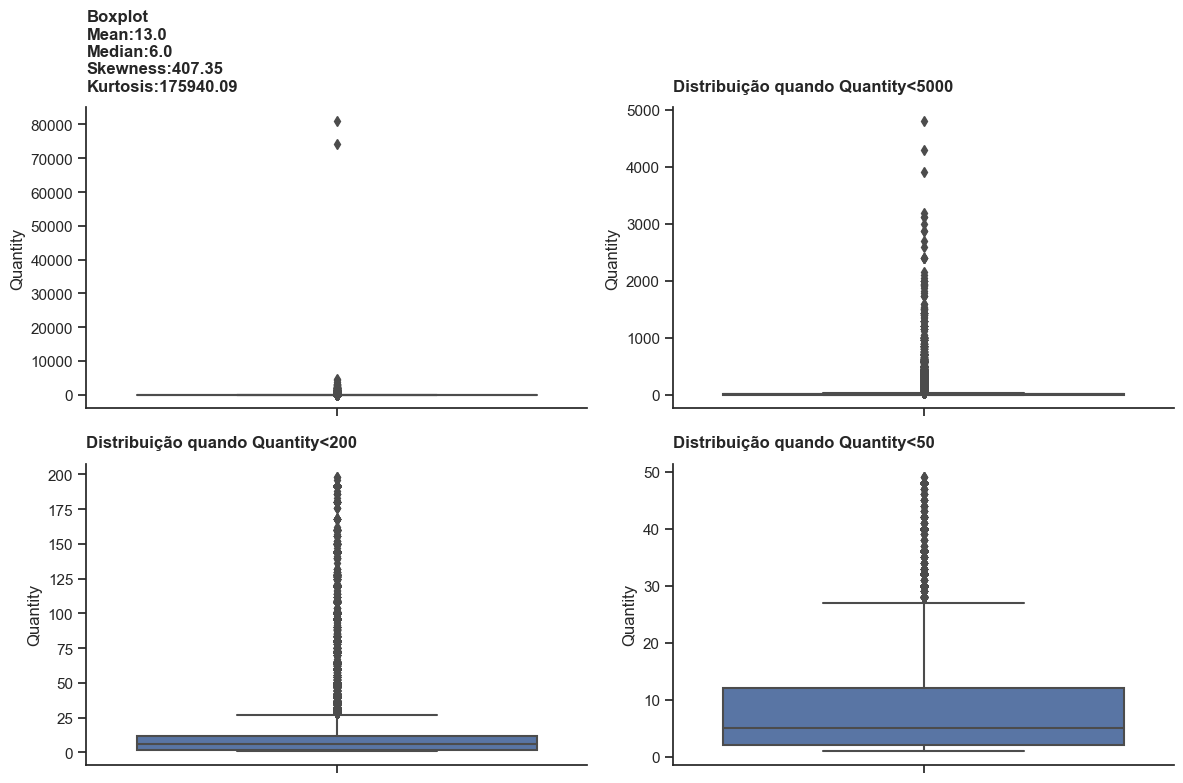

In [748]:
# Distribuição da variável Quantity
limits = [df.Quantity, df[df.Quantity < 5000]['Quantity'], df[df.Quantity < 200]['Quantity'], df[df.Quantity < 50]['Quantity']]
titles = ['Boxplot\nMean:{}\nMedian:{}\nSkewness:{}\nKurtosis:{}'.format(round(df.Quantity.mean(), 0), df.Quantity.median(), round(df.Quantity.skew(), 2), round(df.Quantity.kurtosis(), 2)),
          'Distribuição quando Quantity<5000',
          'Distribuição quando Quantity<200',
          'Distribuição quando Quantity<50']

plt.figure(figsize=(12, 8))

for i, (data, title) in enumerate(zip(limits, titles), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=data)
    plt.title(title, fontsize=12, loc='left', pad=12)

plt.tight_layout()
plt.show()

In [749]:
# Removendo UnitPrice igual 0
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]

In [750]:
# Verificação de minimo e maximo na coluna Quantity
min_quantity = df['Quantity'].min()
max_quantity = df['Quantity'].max()

print(f"Valor mínimo de 'Quantity': {min_quantity}")
print(f"Valor máximo de 'Quantity': {max_quantity}")

Valor mínimo de 'Quantity': 1
Valor máximo de 'Quantity': 80995


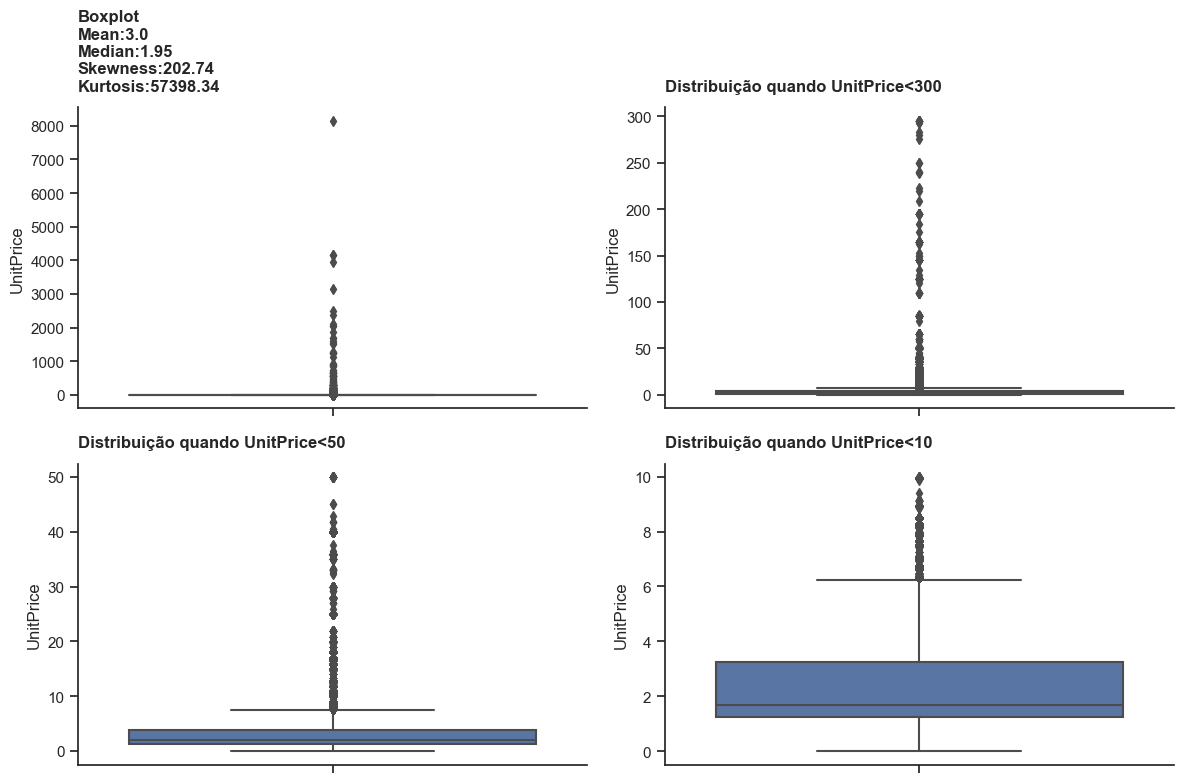

In [751]:
# Distribuição da variável UnitPrice
limits = [df.UnitPrice, df[df.UnitPrice < 300]['UnitPrice'], df[df.UnitPrice < 50]['UnitPrice'], df[df.UnitPrice < 10]['UnitPrice']]
titles = ['Boxplot\nMean:{}\nMedian:{}\nSkewness:{}\nKurtosis:{}'.format(round(df.UnitPrice.mean(), 0), df.UnitPrice.median(), round(df.UnitPrice.skew(), 2), round(df.UnitPrice.kurtosis(), 2)),
          'Distribuição quando UnitPrice<300',
          'Distribuição quando UnitPrice<50',
          'Distribuição quando UnitPrice<10']

plt.figure(figsize=(12, 8))

for i, (data, title) in enumerate(zip(limits, titles), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=data)
    plt.title(title, fontsize=12, loc='left', pad=12)

plt.tight_layout()
plt.show()

Após observar o boxplot, fica evidente que algumas compras apresentavam quantidades superiores a 70000, confirmando o que foi constatado pela análise estatística descritiva. Optei por manter esses dados, até por ser compras atipicas. Além disso, procedi com a exclusão dos registros onde o 'UnitPrice' era igual a 0, pois essa condição pode indicar possíveis inconsistências nos dados.

### Análise Cohort
Análise cohort é a prática de observação de um grupo específico de indivíduos, segmentados a partir de padrões de comportamento em comum. Seu objetivo é uma melhor compreensão de um conjunto de consumidores, o que permite o entendimento de sua jornada de compra e posterior adequação a ela, reduzindo ociclo de vendas.

Para análise de Cohort é preciso criar algumas varáveis: 

* InvoiceMonth: Ano e mês de uma única transação
* CohortMonth: Ano e mês da primeira compra de um cliente. Este rótulo é comum a todas as transações de um cliente específico.
* Period: Uma representação do estágio de um cliente em sua “vida útil”. O número representa o número de meses passados desde a primeira compra.

In [752]:
# Valor total da transação
df['Amount'] = df['Quantity']*df['UnitPrice']

# Criação da variável InvoiceMonth
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12


In [755]:
# Criação da variável Cohort
df['Cohort'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Criação da variável Period 
# Calcula a diferença em dias entre 'InvoiceMonth' e 'Cohort'
df['Period'] = (df.InvoiceMonth - df.Cohort).apply(lambda x: x.n)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,InvoiceMonth,Cohort,Period
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-12,2010-12,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12,2010-12,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-12,2010-12,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12,2010-12,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12,2010-12,0


In [756]:
# Aquisaão e retensão de clientes
tb_cohort = df.pivot_table(index='Cohort', columns='Period', values='CustomerID', aggfunc='nunique')
tb_cohort

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,885.00,324.00,286.00,340.00,321.00,352.00,321.00,309.00,313.00,350.00,331.00,445.00,235.00
2011-01,417.00,92.00,111.00,96.00,134.00,120.00,103.00,101.00,125.00,136.00,152.00,49.00,NaN
2011-02,380.00,71.00,71.00,108.00,103.00,94.00,96.00,106.00,94.00,116.00,26.00,NaN,NaN
2011-03,452.00,68.00,114.00,90.00,101.00,76.00,121.00,104.00,126.00,39.00,NaN,NaN,NaN
2011-04,300.00,64.00,61.00,63.00,59.00,68.00,65.00,78.00,22.00,NaN,NaN,NaN,NaN
2011-05,284.00,54.00,49.00,49.00,59.00,66.00,75.00,27.00,NaN,NaN,NaN,NaN,NaN
2011-06,242.00,42.00,38.00,64.00,56.00,81.00,23.00,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.00,34.00,39.00,42.00,51.00,21.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.00,35.00,42.00,41.00,21.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 A tabela acima mostra a retenção e aquisição de clientes:

* Na vertical, na coluna '0' informa quantos novos clientes a empresa conquistou em um determinado mês. Por exemplo, 884 indica o número de clientes em dezembro de 2010, enquanto 415 é o número de clientes em janeiro de 2011, e assim sucessivamente.

* Na disposição horizontal, a primeira linha mostra o número de clientes que permanecem ativos desde a sua primeira compra, ou seja, desde dezembro de 2010. Por exemplo, 323 indica o número de clientes dos 884 que continuaram comprando um mês após sua primeira compra, 286 indica o número de clientes que continuaram comprando dois meses após a primeira compra, e assim por diante.

In [762]:
# Tabela de retenção
cohort_size = tb_cohort.iloc[:,0]

tb_retencao = tb_cohort.divide(cohort_size, axis=0)
#tb_retencao.index = pd.to_datetime(tb_retencao.index).date
tb_retencao.round(3) * 100 

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,100.00,36.60,32.30,38.40,36.30,39.80,36.30,34.90,35.40,39.50,37.40,50.30,26.60
2011-01,100.00,22.10,26.60,23.00,32.10,28.80,24.70,24.20,30.00,32.60,36.50,11.80,NaN
2011-02,100.00,18.70,18.70,28.40,27.10,24.70,25.30,27.90,24.70,30.50,6.80,NaN,NaN
2011-03,100.00,15.00,25.20,19.90,22.30,16.80,26.80,23.00,27.90,8.60,NaN,NaN,NaN
2011-04,100.00,21.30,20.30,21.00,19.70,22.70,21.70,26.00,7.30,NaN,NaN,NaN,NaN
2011-05,100.00,19.00,17.30,17.30,20.80,23.20,26.40,9.50,NaN,NaN,NaN,NaN,NaN
2011-06,100.00,17.40,15.70,26.40,23.10,33.50,9.50,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.00,18.10,20.70,22.30,27.10,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.00,20.70,24.90,24.30,12.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observações:**

A tabela acima representa os valores em porcentagens, oferecendo uma visão da interação do cliente com o negócio ao longo do tempo. Por exemplo, em janeiro de 2011, o negócio adquiriu novos clientes, mas após um mês, apenas 21,9% desses clientes permaneceram ou retornaram para novas compras. Posteriormente, esse número aumentou para 26,7%, indicando que alguns clientes retornaram e efetuaram novas compras, possivelmente motivados por convites ou ofertas direcionadas a esse grupo específico de clientes.

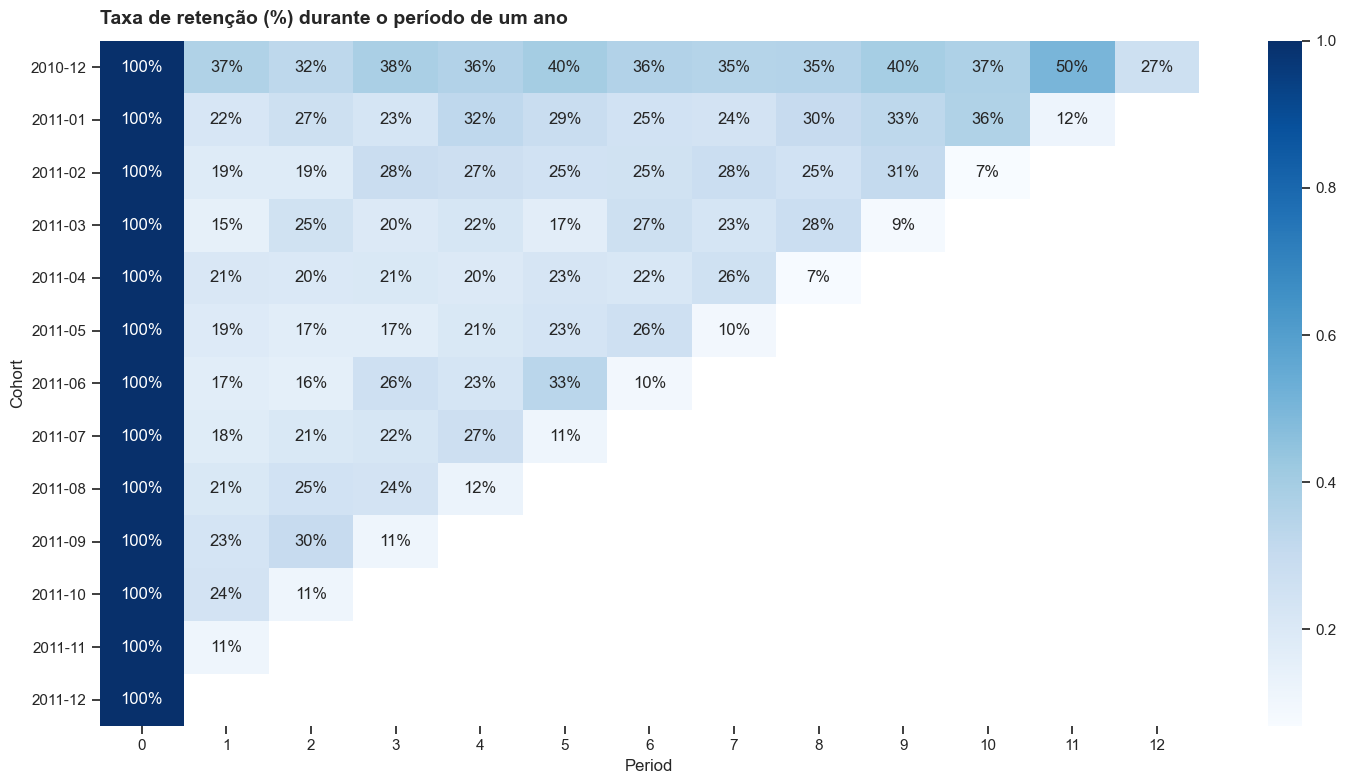

In [763]:
#Gráfico Taxa de rentenção
plt.figure(figsize=(15, 8))

sns.heatmap(data=tb_retencao, annot = True, fmt = '.0%', cmap='Blues')
plt.title('Taxa de retenção (%) durante o período de um ano', fontsize=14, loc='left', pad=12)
plt.tight_layout()
plt.show()

In [764]:
# Tabela Valor médio gasto
amount_cohort= df.pivot_table(index='Cohort', columns='Period', values='Amount', aggfunc='mean').round(2)
amount_cohort

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,22.22,27.27,26.86,27.19,21.19,28.14,28.34,27.43,29.25,33.47,33.99,23.64,25.84
2011-01,26.88,25.10,20.97,31.23,22.48,26.28,25.24,25.49,19.07,22.33,19.73,19.78,NaN
2011-02,17.87,20.85,21.46,19.36,17.69,16.98,22.17,22.90,18.79,22.18,23.50,NaN,NaN
2011-03,17.59,21.14,22.69,18.02,21.11,19.00,22.03,19.99,16.81,13.20,NaN,NaN,NaN
2011-04,16.95,21.03,19.49,18.74,19.55,15.00,15.25,15.97,12.34,NaN,NaN,NaN,NaN
2011-05,20.48,17.34,22.25,20.90,18.59,14.12,17.02,234.53,NaN,NaN,NaN,NaN,NaN
2011-06,23.98,16.29,19.95,20.45,15.35,16.71,13.22,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,14.96,23.53,11.79,13.02,10.88,11.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,16.52,13.16,12.53,15.88,17.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observação:**

A tabela acima exibe a média de gastos do grupo de clientes ao longo do tempo. Por exemplo, para o grupo de clientes de janeiro de 2011, o gasto médio inicial foi de 19,79. Após um mês, houve um acréscimo de 24,47 em relação ao período anterior, totalizando 24,47. Após dois meses, o gasto médio foi de 20,98, e esse padrão continua para os períodos subsequentes.

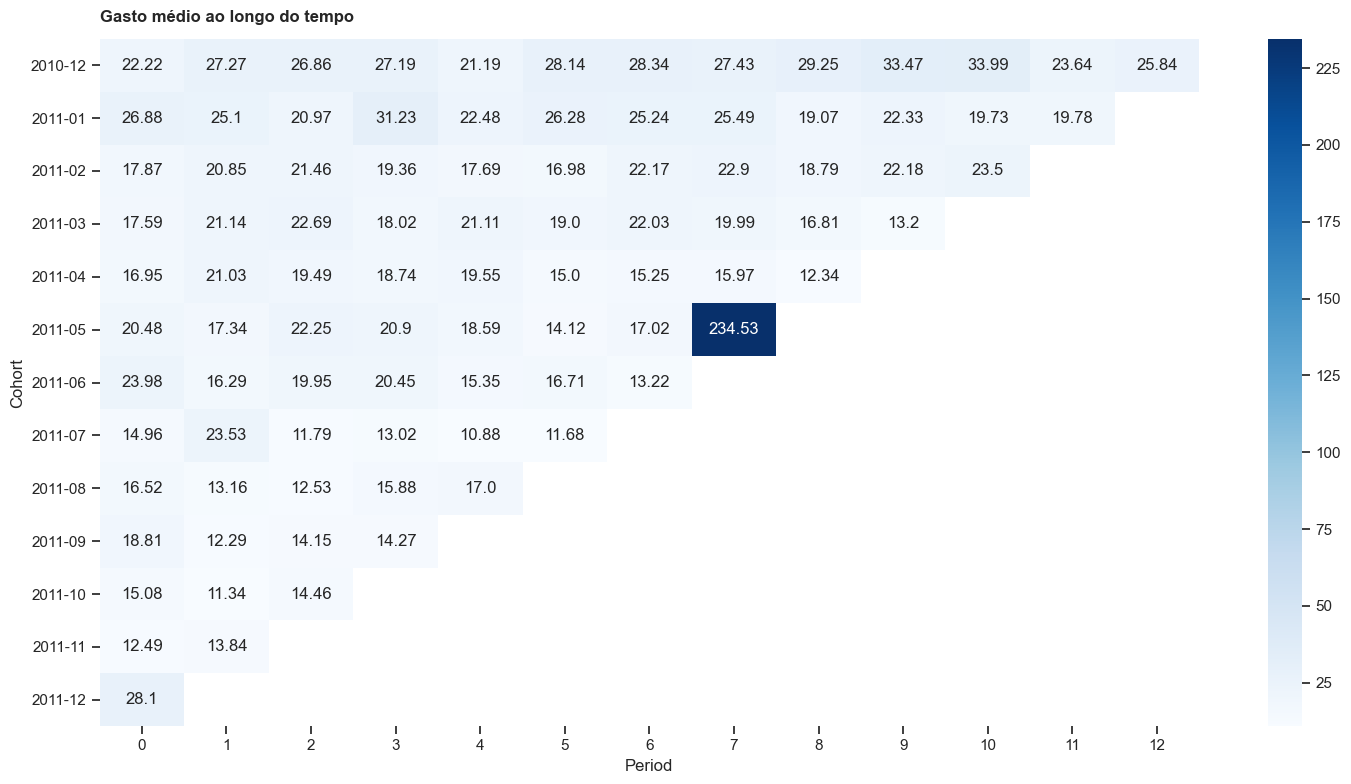

In [776]:
#Gráfico Valor médio gasto
plt.figure(figsize=(15, 8))
sns.heatmap(data=amount_cohort, annot=True, fmt='0', cmap='Blues')
plt.title('Gasto médio ao longo do tempo', fontsize=12, loc='left', pad=12)
plt.tight_layout()
plt.show()

### Análise RFV

Aanálise RFV é uma técnica usada no marketing para segmentar e entender melhor os clientes com base em seu histórico de compras e comportamento.

* Recência (Recency): Refere-se ao tempo desde a última compra de um cliente. Clientes que compraram recentemente podem estar mais propensos a comprar novamente do que aqueles que não o fizeram há muito tempo.
    * Ordenar por ordem crescente, ou seja, quanto menor a recência, maior a pontuação (isso significa que quanto mais recente ele comprou, melhor).


* Frequência (Frequency): Indica a frequência com que um cliente faz compras. Clientes que compram com mais frequência podem ser considerados mais engajados e leais.
    * Ordenar por ordem decrescente, ou seja, quanto mais compras, maior a pontuação.


* Valor (Monetary Value): Relacionado ao valor total gasto por um cliente em um determinado período. Isso ajuda a identificar clientes de alto valor que podem merecer estratégias de marketing específicas.
    * Ordenar por ordem decrescente, ou seja, quanto maior valor financeiro, maior a pontuação.

In [783]:
# Base de daods RFV
df_rfv = df.copy()
df_rfv = df_rfv.iloc[:,:9]
df_rfv

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60


In [784]:
# Obtendo a data mais recente no conjunto de dados
max_date = df_rfv['InvoiceDate'].max()

# Calculando a Recência, Frequência e Valor para cada Cliente
df_rfv = df_rfv.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (max_date - date.max()).days + 1,  # Recência
    'InvoiceNo': 'count',  # Frequência
    'Amount': 'sum'  # Valor
}).reset_index()

# Renomeando as colunas
df_rfv.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
df_rfv.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.00,326,1,77183.60
1,12347.00,2,182,4310.00
2,12348.00,75,31,1797.24
3,12349.00,19,73,1757.55
4,12350.00,310,17,334.40


In [785]:
df_rfv.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

,CustomerID,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00,4338.00
mean,15300.41,92.54,90.52,2048.69
std,1721.81,100.01,225.51,8985.23
min,12346.00,1.00,1.00,3.75
25%,13813.25,18.00,17.00,306.48
50%,15299.50,51.00,41.00,668.57
75%,16778.75,142.00,98.00,1660.60
90%,17687.20,263.00,202.30,3640.84
95%,17984.15,312.00,308.00,5790.00
99%,18225.63,369.00,655.63,19780.49


In [786]:
# Criação da coluna score
df_rfv['recency_score'] = pd.cut(df_rfv['Recency'], bins=[0,18,51,143,263,375], labels=[5,4,3,2,1])
df_rfv['recency_score'] = df_rfv['recency_score'].astype('int')
df_rfv['frequency_score'] = pd.cut(df_rfv['Frequency'], bins=[0,18,42,99,203,7677], labels=[1,2,3,4,5])
df_rfv['frequency_score'] = df_rfv['frequency_score'].astype('int')
df_rfv['monetary_score'] = pd.cut(df_rfv['Monetary'], bins=[1,306,668,1650,3614,290000], labels=[1,2,3,4,5])
df_rfv['monetary_score'] = df_rfv['monetary_score'].astype('int')
df_rfv

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
0,12346.00,326,1,77183.60,1,1,5
1,12347.00,2,182,4310.00,5,4,5
2,12348.00,75,31,1797.24,3,2,4
3,12349.00,19,73,1757.55,4,3,4
4,12350.00,310,17,334.40,1,1,2
...,...,...,...,...,...,...,...
4333,18280.00,278,10,180.60,1,1,1
4334,18281.00,181,7,80.82,2,1,1
4335,18282.00,8,12,178.05,5,1,1
4336,18283.00,4,721,2045.53,5,5,4


#### Recência

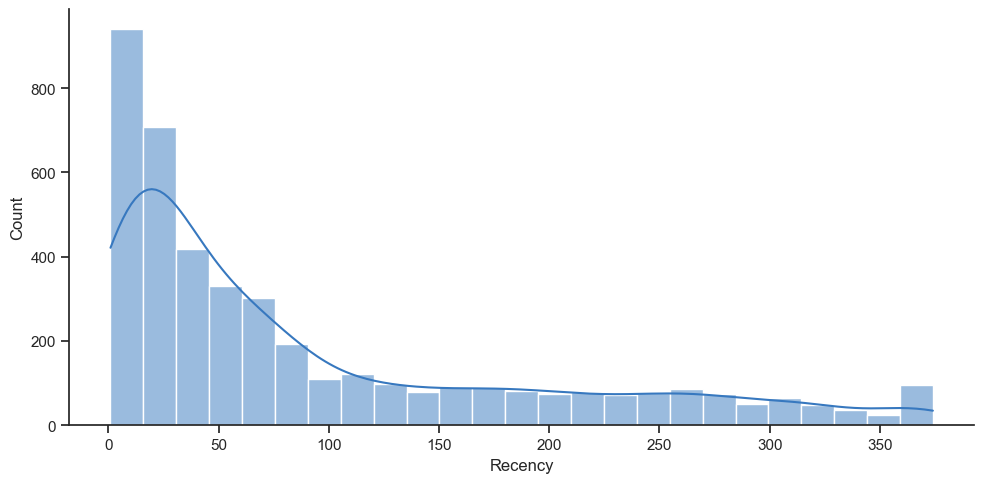

In [787]:
#Gráfico de Recência
plt.subplots(figsize=(10, 5))
sns.histplot(x='Recency', data=df_rfv, kde=True, color=sns.xkcd_rgb['windows blue'])
plt.tight_layout()
plt.show()

In [788]:
# Calculando a porcentagem para cada score de recência
grouped_recencia = df_rfv.groupby('recency_score').size().reset_index(name='contagem')
total_recencia = grouped_recencia['contagem'].sum()
grouped_recencia['porcentagem'] = (grouped_recencia['contagem'] / total_recencia) * 100
grouped_recencia

,recency_score,contagem,porcentagem
0,1,431,9.94
1,2,645,14.87
2,3,1074,24.76
3,4,1063,24.50
4,5,1125,25.93


#### Frequência

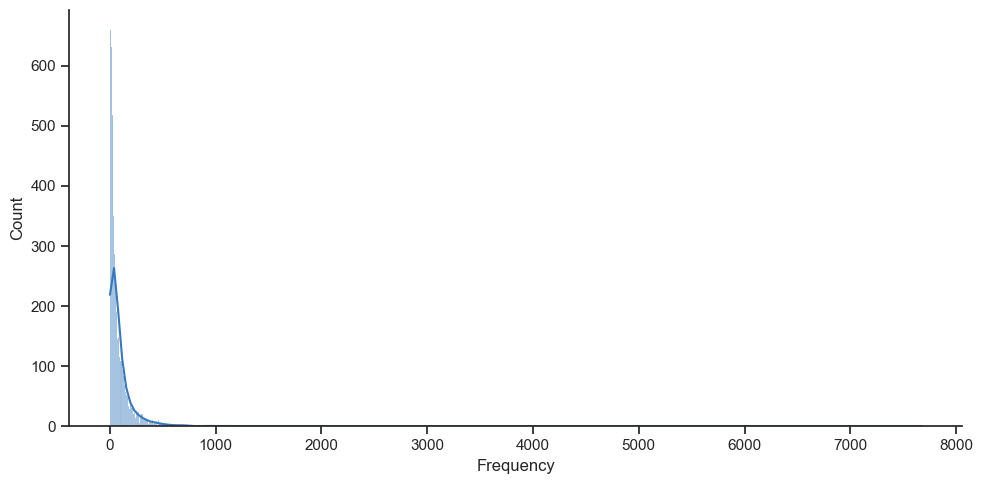

In [789]:
#Gráfico de Frequência
plt.subplots(figsize=(10, 5))
sns.histplot(x='Frequency', data=df_rfv, kde=True, color=sns.xkcd_rgb['windows blue'])
#plt.xlim(0, 30)
plt.tight_layout()
plt.show()

In [790]:
# Calculando a porcentagem para cada score de frequência
grouped_frequencia = df_rfv.groupby('frequency_score').size().reset_index(name='contagem')
total_frequencia = grouped_frequencia['contagem'].sum()
grouped_frequencia['porcentagem'] = (grouped_frequencia['contagem'] / total_frequencia) * 100
grouped_frequencia

,frequency_score,contagem,porcentagem
0,1,1167,26.90
1,2,1058,24.39
2,3,1041,24.00
3,4,639,14.73
4,5,433,9.98


#### Valor

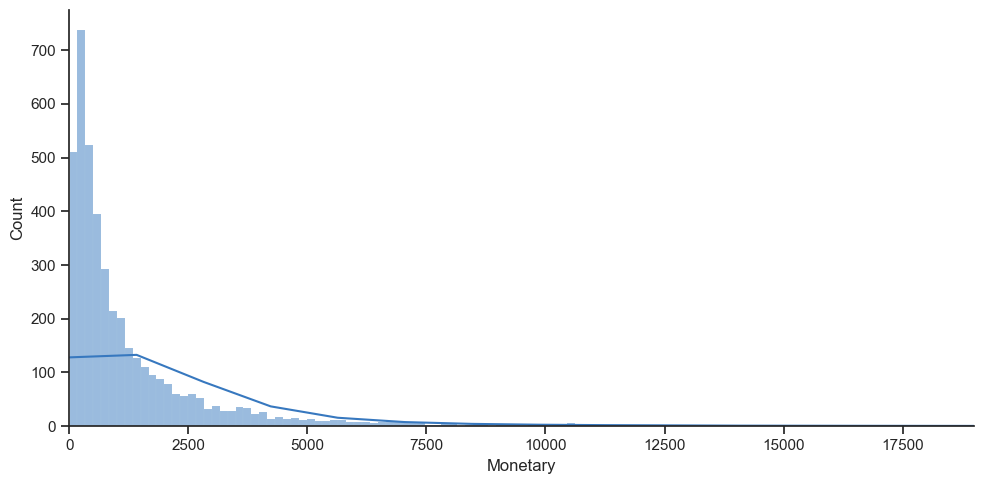

In [791]:
#Gráfico de Valor
plt.subplots(figsize=(10, 5))
sns.histplot(x='Monetary', data=df_rfv, kde=True, color=sns.xkcd_rgb['windows blue'])
plt.xlim(0, 19000)
plt.tight_layout()
plt.show()

In [793]:
# Calculando a porcentagem para cada score de valor
sum_valor = df_rfv.groupby('monetary_score')['Monetary'].sum().reset_index(name='soma_valor')

grouped_valor = df_rfv.groupby('monetary_score').size().reset_index(name='contagem')
total_valor = grouped_valor['contagem'].sum()
grouped_valor['porcentagem'] = (grouped_valor['contagem'] / total_valor) * 100          
grouped_valor = grouped_valor.merge(sum_valor, on='monetary_score')
grouped_valor

,monetary_score,contagem,porcentagem,soma_valor
0,1,1082,24.94,192247.34
1,2,1085,25.01,500288.83
2,3,1081,24.92,1148806.79
3,4,650,14.98,1562692.03
4,5,440,10.14,5483173.90


#### Segmentação

Para uma compreensão mais detalhada do comportamento dos clientes, é comum utilizar uma matriz bidimensional que analisa a Recência e a Média entre Frequência e Valor (F+V). Esse índice RFV é calculado para cada cliente, oferecendo uma visão abrangente sobre seu engajamento e potencial de gastos.

Após atribuir pontuações RFV aos clientes, o próximo passo é a segmentação. Diversos métodos são utilizados para dividir a base de clientes com base nessa análise. Essa abordagem possibilita estratégias de marketing mais direcionadas, como a identificação de clientes de alto valor, a reativação dos inativos ou o fortalecimento da lealdade de clientes regulares.

Para este projeto foi utilizado os segmentos abaixo:


| Segmento de clientes       | Atividade                                                                                     | Recency_score | Mean_score |
|----------------------------|-----------------------------------------------------------------------------------------------|---------------|------------|
| Campeões                   | Comprou recentemente. Compra com frequência. E gasta muito!                                  | 4 a 5         | 4 a 5      |
| Clientes Fiéis             | Gasta um bom dinheiro. Com frequentemente.                                                    | 2 a 5         | 3 a 5      |
| Lealdade potencial         | Clientes recentes. Gastaram uma boa quantia. Compraram mais de uma vez.                       | 3 a 5         | 1 a 3      |
| Clientes Recentes          | Comprou recentemente. Mas não com frequência.                                                  | 4 a 5         | 0 a 1      |
| Promissor                  | Compradores recentes. Mas não gastaram muito.                                                  | 3 a 4         | 0 a 1      |
| Precisam de atenção        | Recência, frequência e valores monetários acima da média. (Pode não ter comprado muito recentemente). | 2 a 3     | 2 a 3      |
| Prestes a Hibernar         | Abaixo da média da Recência, Frequência e valores monetários. (Os perderá se não for reativado). | 2 a 3      | 0 a 2      |
| Em risco                   | Gastou muito dinheiro e comprou com freqüência. Mas há muito tempo. (Precisa trazê-los de volta)! | 0 a 2         | 2 a 5      |
| Não posso perdê-los        | Fez grandes compras e com frequência. Mas há algum tempo.                                      | 0 a 1         | 4 a 5      |
| Hibernando                 | A última compra foi feita a algum tempo. Pouco gasto e baixo número de pedidos.                | 1 a 2         | 1 a 2      |
| Perdido                    | Recência, frequência e pontuação monetária mais baixas.                                        | 0 a 2         | 0 a 2      |


In [794]:
# Criação da coluna mean_score
df_rfv['mean_score'] = (df_rfv['frequency_score'] + df_rfv['monetary_score']) / 2
df_rfv['score'] = df_rfv[['recency_score','frequency_score','monetary_score']].sum(axis=1)
df_rfv.head()

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,mean_score,score
0,12346.00,326,1,77183.60,1,1,5,3.00,7
1,12347.00,2,182,4310.00,5,4,5,4.50,14
2,12348.00,75,31,1797.24,3,2,4,3.00,9
3,12349.00,19,73,1757.55,4,3,4,3.50,11
4,12350.00,310,17,334.40,1,1,2,1.50,4


In [796]:
# Média por score
df_rfv.groupby('score').agg({'Recency': 'mean','Frequency': 'mean', 'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
         mean      mean     mean count
score                                 
3      319.20      8.00   156.70   186
4      244.30     11.90   205.70   298
5      171.90     16.30   279.10   392
6      130.90     21.60   375.40   454
7       83.80     27.20   649.10   438
8       75.50     38.90   900.90   455
9       60.70     54.30   936.30   437
10      43.90     75.10  1305.30   395
11      32.10     97.00  2191.50   378
12      26.50    136.90  2518.20   280
13      16.60    183.00  3743.50   239
14      13.90    289.20  7057.00   196
15       6.70    595.00 16245.20   190

In [797]:
# Criando as categorias de segmentação
segmentos = {
    'Campeões': lambda rec, mean: 4 <= rec <= 5 and 4 <= mean <= 5,
    'Clientes Fiéis': lambda rec, mean: 2 <= rec <= 5 and 3 <= mean <= 5,
    'Lealdade Potencial': lambda rec, mean: 3 <= rec <= 5 and 1 <= mean < 3,
    'Clientes Recentes': lambda rec, mean: 4 <= rec <= 5 and 0 <= mean < 2,
    'Promissor': lambda rec, mean: 3 <= rec <= 4 and 0 <= mean < 2,
    'Precisam de Atenção': lambda rec, mean: 2 <= rec <= 3 and 2 <= mean <= 3,
    'Prestes a Hibernar': lambda rec, mean: 2 <= rec <= 3 and 0 <= mean <= 2,
    'Em risco': lambda rec, mean: 0 <= rec <= 2 and 2 <= mean <= 5,
    'Não posso perdê-los': lambda rec, mean: 0 <= rec <= 1 and 4 <= mean <= 5,
    'Hibernando': lambda rec, mean: 1 <= rec <= 2 and 1 <= mean <= 2,
    'Perdido': lambda rec, mean: 0 <= rec <= 2 and 0 <= mean <= 2
}

# Função para aplicar a segmentação com base nos intervalos definidos
def segmentar(row):
    recency = row['recency_score']
    mean_score = row['mean_score']
    for segmento, condicao in segmentos.items():
        if condicao(recency, mean_score):
            return segmento
    return 'Outro'  

# Aplicando a função para criar a coluna 'Segmento'
df_rfv['segment'] = df_rfv.apply(segmentar, axis=1)
df_rfv

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,mean_score,score,segment
0,12346.00,326,1,77183.60,1,1,5,3.00,7,Em risco
1,12347.00,2,182,4310.00,5,4,5,4.50,14,Campeões
2,12348.00,75,31,1797.24,3,2,4,3.00,9,Clientes Fiéis
3,12349.00,19,73,1757.55,4,3,4,3.50,11,Clientes Fiéis
4,12350.00,310,17,334.40,1,1,2,1.50,4,Hibernando
...,...,...,...,...,...,...,...,...,...,...
4333,18280.00,278,10,180.60,1,1,1,1.00,3,Hibernando
4334,18281.00,181,7,80.82,2,1,1,1.00,4,Prestes a Hibernar
4335,18282.00,8,12,178.05,5,1,1,1.00,7,Lealdade Potencial
4336,18283.00,4,721,2045.53,5,5,4,4.50,14,Campeões


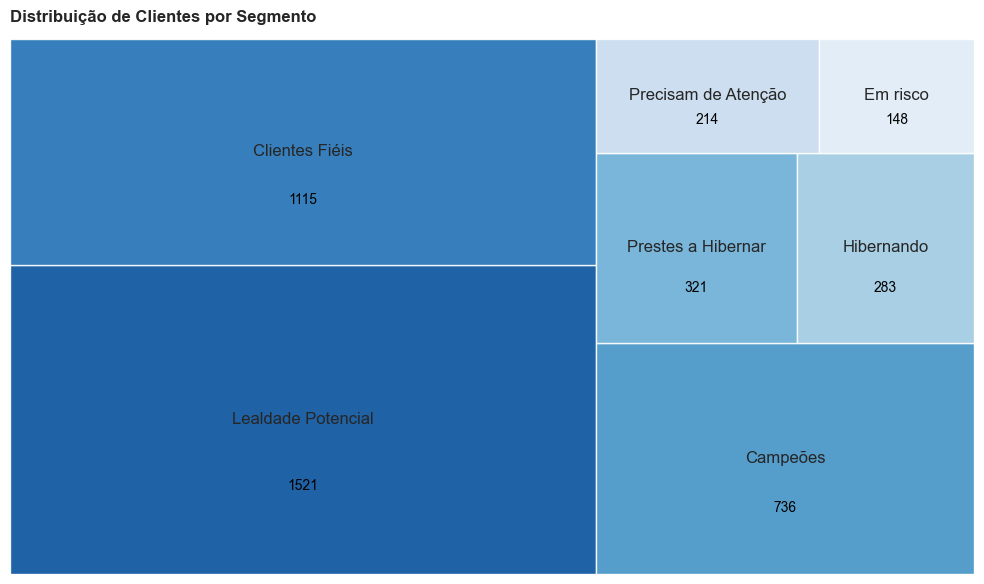

In [798]:
# Criando o gráfico de árvore (tree map)
segment_count = df_rfv['segment'].value_counts()

plt.figure(figsize=(10, 6))
ax = squarify.plot(sizes=segment_count.values, label=segment_count.index, color=sns.color_palette("Blues_r", len(segment_count)), alpha=0.9)

# Adicionando os valores no centro de cada retângulo
for i, size in enumerate(segment_count.values):
    x, y, dx, dy = ax.get_children()[i].get_bbox().bounds
    plt.text(x + dx / 2, y + dy / 3.5, f"{size}", horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')

plt.title('Distribuição de Clientes por Segmento', fontsize=12, loc='left', pad=12)
plt.axis('off')
plt.tight_layout()
plt.show()

### Segmentação com k-Means

In [799]:
# Base de dados para clusterização
df_kmeans = df_rfv.copy()
df_kmeans = df_kmeans.iloc[:,:4]
df_kmeans.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.00,326,1,77183.60
1,12347.00,2,182,4310.00
2,12348.00,75,31,1797.24
3,12349.00,19,73,1757.55
4,12350.00,310,17,334.40


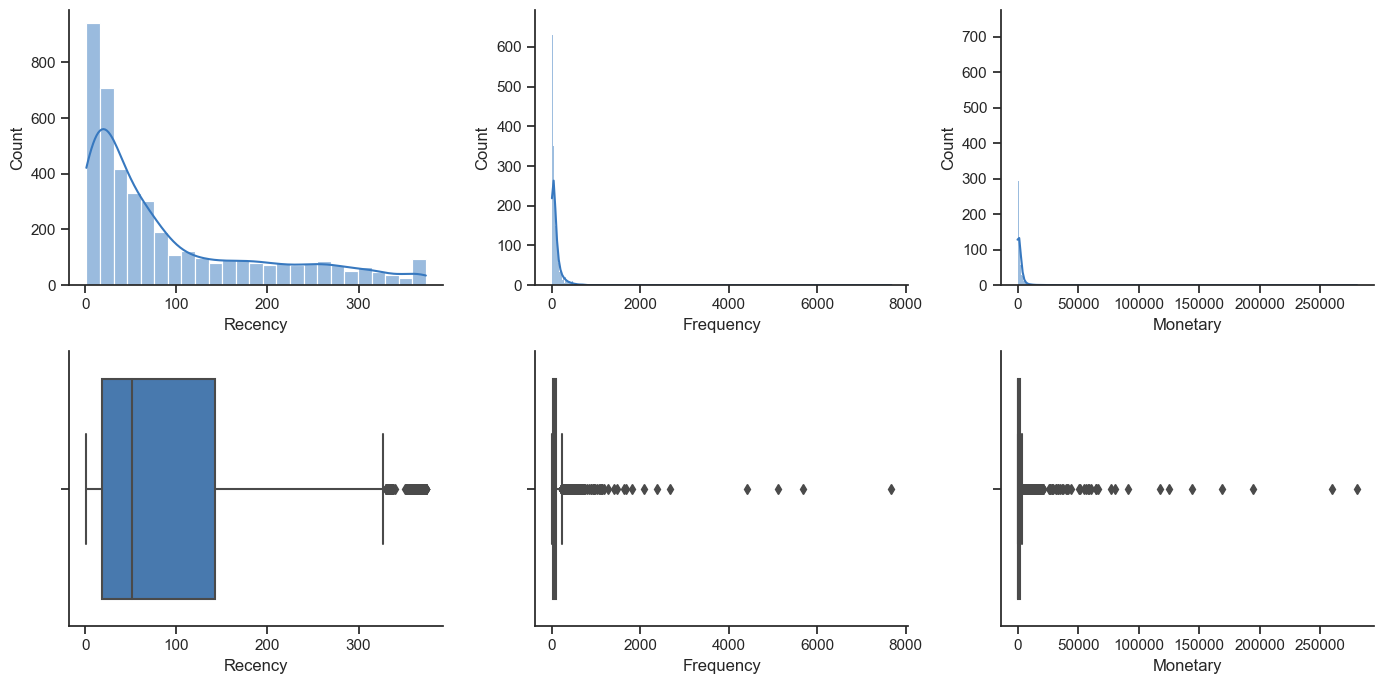

In [612]:
# Gráfico de distribuição
features = ['Recency', 'Frequency', 'Monetary']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 7), constrained_layout=True)

for j, feature in enumerate(features):
    sns.histplot(ax=ax[0, j], data=df_kmeans, x=feature, kde=True, color=sns.xkcd_rgb['windows blue'])
    sns.boxplot(ax=ax[1, j], data=df_kmeans, x=feature, color=sns.xkcd_rgb['windows blue'])

plt.tight_layout()
plt.show()

Conforme gráfico acima a distribuição dos dados é não simétrica.

#### Implementação de Clustering K-Means

In [718]:
# Modelo
cols = ['Recency','Frequency','Monetary']

standardized_df = df_kmeans.copy()

scaler = StandardScaler()
scaler.fit(df_kmeans[cols])

standardized_features = scaler.transform(df_kmeans[cols])
standardized_df[cols] = standardized_features

Escolhendo um número de clusters

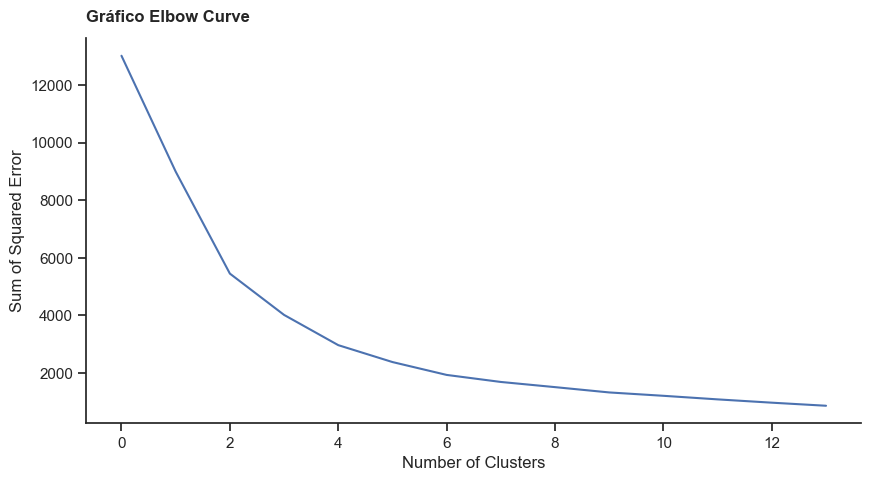

In [719]:
# Gráfico Elbow Curve para decidir K
ssd = []
for k in list(range(1,15)):
    model= KMeans(n_clusters = k)
    model.fit(standardized_df[cols])
    ssd.append(model.inertia_)
    
plt.figure(figsize=(10,5))
plt.plot(ssd, '')

plt.title('Gráfico Elbow Curve', fontsize=12, loc='left', pad=12)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.show()

In [733]:
# Clusterização
model = KMeans(n_clusters= 3, random_state=1)
model.fit(standardized_df[cols])

df_kmeans['Cluster'] = model.labels_

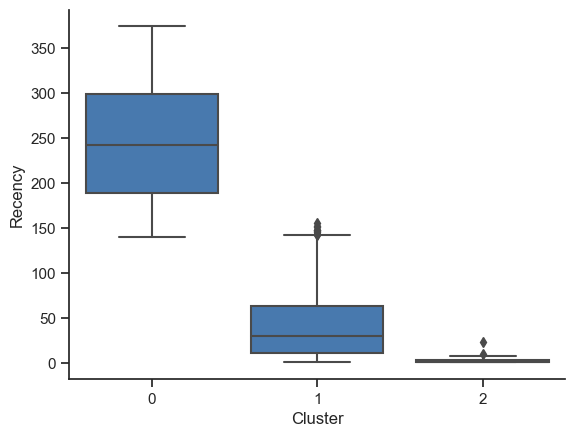

In [734]:
# Recency
sns.boxplot(x='Cluster', y='Recency', data=df_kmeans, color=sns.xkcd_rgb['windows blue'])
plt.show()

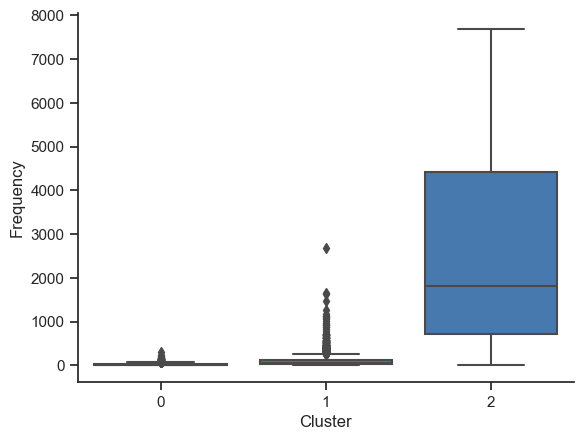

In [731]:
# Frequency
sns.boxplot(x='Cluster', y='Frequency', data=df_kmeans, color=sns.xkcd_rgb['windows blue'])
plt.show()

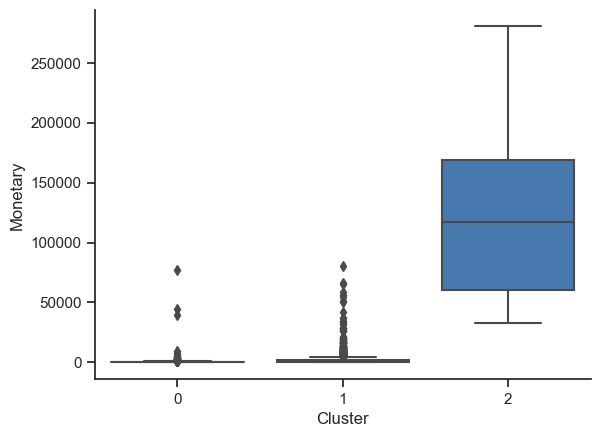

In [732]:
# Monetary
sns.boxplot(x='Cluster', y='Monetary', data=df_kmeans, color=sns.xkcd_rgb['windows blue'])
plt.show()

A segmentação de cluster feita com KMeans dividiu os clientes em três grupos distintos:

- O Cluster 0 representa os clientes menos engajados com a empresa. Eles compram com pouca frequência e gastam pouco dinheiro. É importante focar em estratégias de retenção para esses clientes, como oferecer descontos ou promoções especiais.
- O Cluster 1 representa os clientes neutros. Eles compram com frequência regular e gastam uma quantia moderada de dinheiro. É importante manter esses clientes satisfeitos e continuar oferecendo-lhes produtos e serviços de qualidade.
- O Cluster 2 representa os clientes mais engajados com a empresa. Eles compram com frequência e gastam muito dinheiro. É importante fidelizar esses clientes e oferecer-lhes benefícios exclusivos, como acesso a produtos ou serviços premium.

In [738]:
# Verificação das métricas de cada cluster:
media = (
    df_kmeans.groupby("Cluster")
  [["CustomerID", "Recency", "Frequency", "Monetary"]]
    .agg(
        {
          "CustomerID": "nunique",
          "Recency": "mean",
          "Frequency": "mean",
          "Monetary": "mean",  
        }
    )
    .reset_index()
)

media = media.rename(columns={"CustomerID": "Buyers"})
media.sort_values(by="Recency", ascending=True)

,Cluster,Buyers,Recency,Frequency,Monetary
2,2,13,4.69,2535.92,125981.34
1,1,3245,41.38,101.73,2022.48
0,0,1080,247.31,27.40,635.65


#### Conclusão

Foi abordado o processo de obtenção de valores RFV a partir dos dados de compra do cliente, além da realização de segmentações por meio de quantis RFV e métodos de clusterizaçõ com K-Means. Essas abordagens proporcionam insights valiosos sobre o comportamento dos clientes, permitindo estratégias mais refinadas de marketing e atendimento, baseadas em diferentes perfis de engajamento e padrões de compra.